## Load Libraries and set global variables

In [4]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import utils

from datetime import timedelta
from gluonts.dataset.pandas import PandasDataset
from huggingface_hub import hf_hub_download

# from uni2ts.model.moirai import MoiraiForecast
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
TIME_COL = "Date"
TARGET = "Weekly_Sales"
DYNAMIC_COV = ["IsHoliday", 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
FORECAST_HORIZON = 17 # weeks
FREQ = "W-FRI"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [5]:
# load data and exogenous features
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

# create unique id
df["unique_id"] = df['Store'].astype(str)+'-'+df['Dept'].astype(str)

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 3331


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1-1
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1-1
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,1-1
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,1-1
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,1-1


## Pre-process dataset
- Clean up data
- Select top stores for forecasting

In [6]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable

# reduce running time by forecasting only top 100 stores-depts
top_100_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)
df = df[df['unique_id'].isin(top_100_stores['unique_id'])]

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 100


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
5118,1,38,2010-02-05,115564.35,0,A,medium,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1-38
5119,1,38,2010-02-12,94136.35,1,A,medium,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,1-38
5120,1,38,2010-02-19,98672.59,0,A,medium,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,1-38
5121,1,38,2010-02-26,92755.59,0,A,medium,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,1-38
5122,1,38,2010-03-05,108282.86,0,A,medium,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,1-38


## Split data between train and test

In [7]:
# 17 weeks to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Weeks for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Weeks for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Weeks for training: 126 from 2010-02-05 to 2012-06-29
Weeks for testing: 17 from 2012-07-06 to 2012-10-26


## Forecast

## Dataset Preprocessing
- |Scaling is handled internally

In [8]:
# create GluonTS dataset from pandas
ds = PandasDataset.from_long_dataframe(
    pd.concat([train, test[["unique_id", TIME_COL]+DYNAMIC_COV]]).set_index(TIME_COL), # concatenation with test dynamic covaraiates
    item_id="unique_id",
    feat_dynamic_real=DYNAMIC_COV,
    target=TARGET,
    freq=FREQ
)

### MOIRAI

In [9]:
# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),

    prediction_length=FORECAST_HORIZON,
    context_length=100,
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    # map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)

# convert forecast into pandas
forecast_df = utils.moirai_forecast_to_pandas(forecasts, test, FORECAST_HORIZON, TIME_COL)
forecast_df.to_csv('moirai.csv', index=False)
test.to_csv('test_.csv', index=False)

/usr/local/lib/python3.10/site-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

## Plot Actuals and Forecast

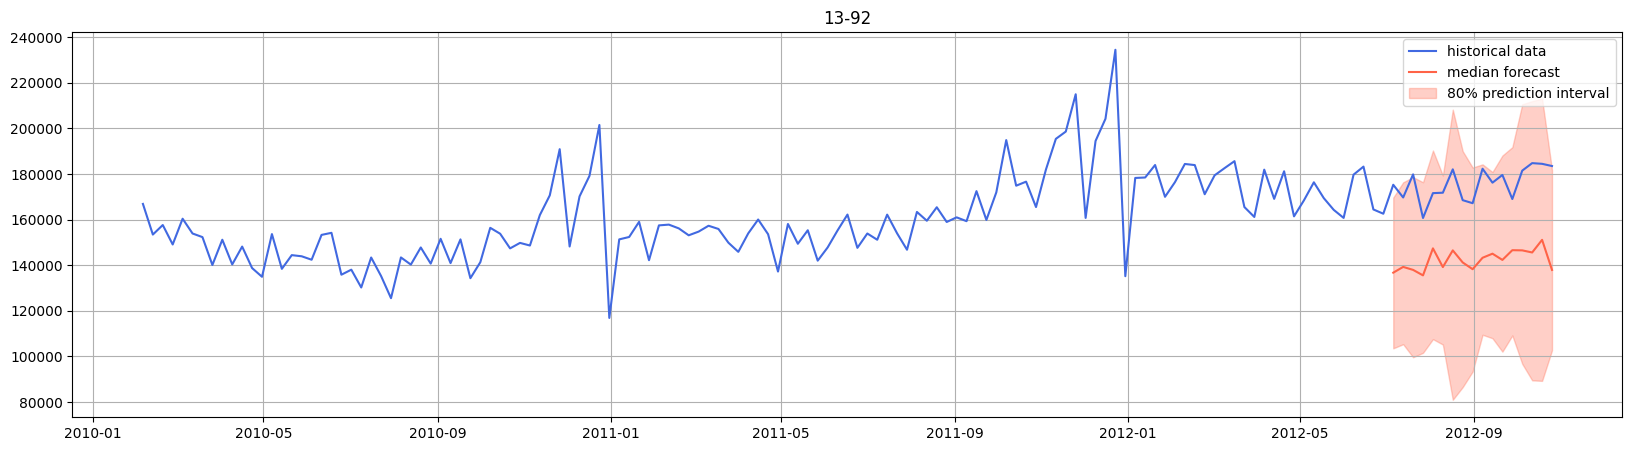

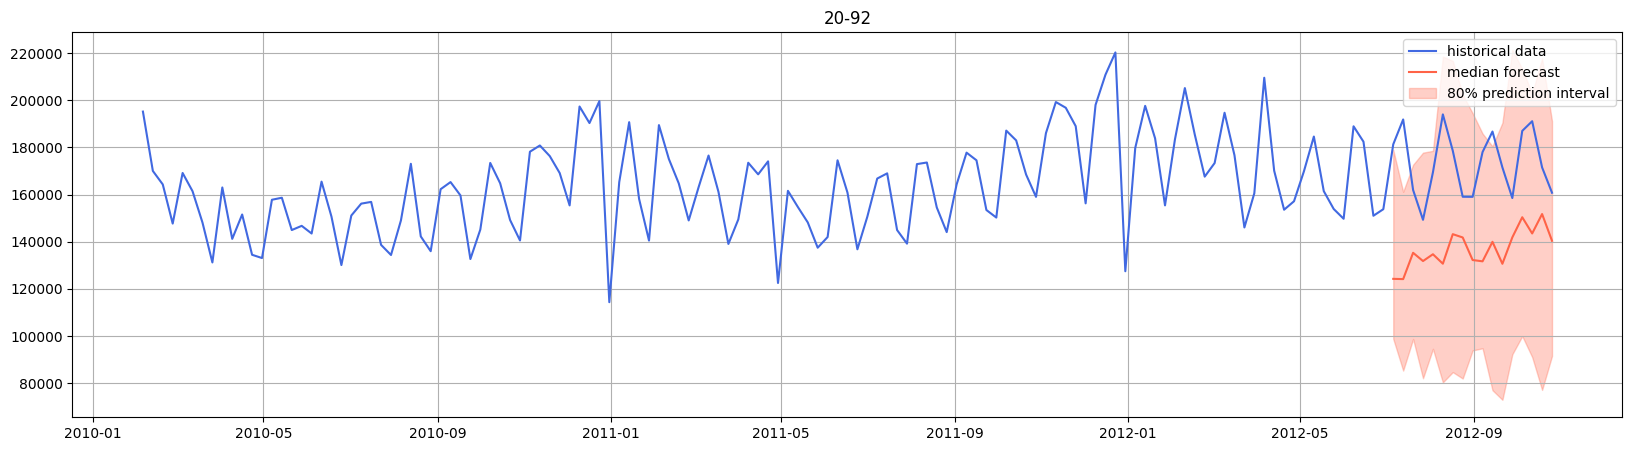

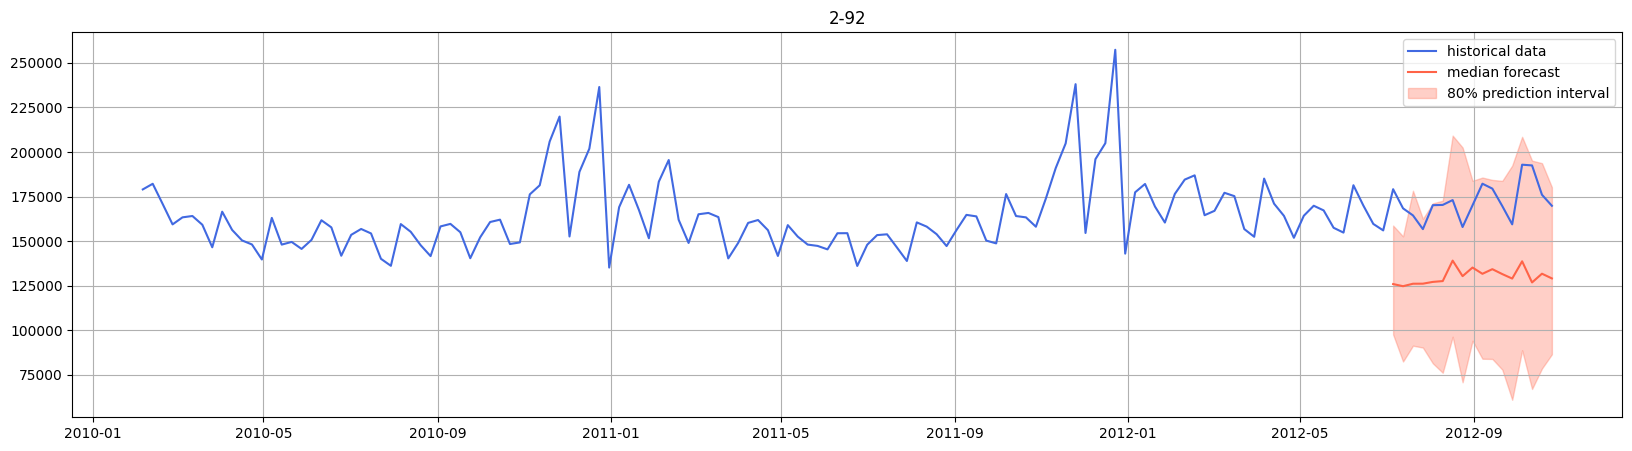

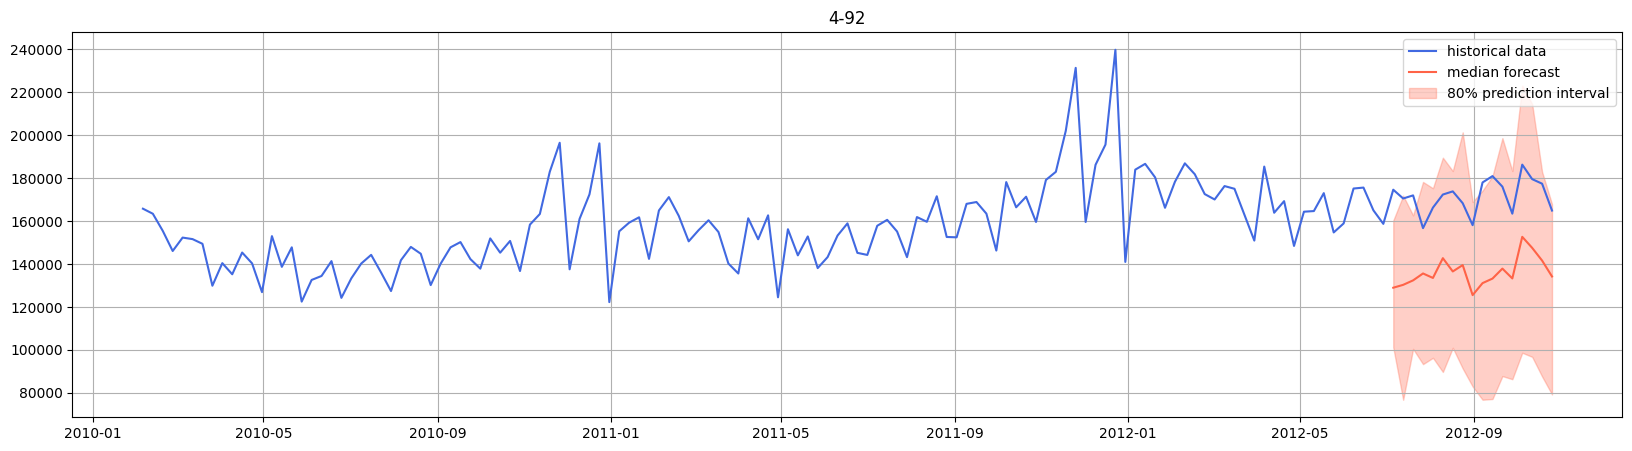

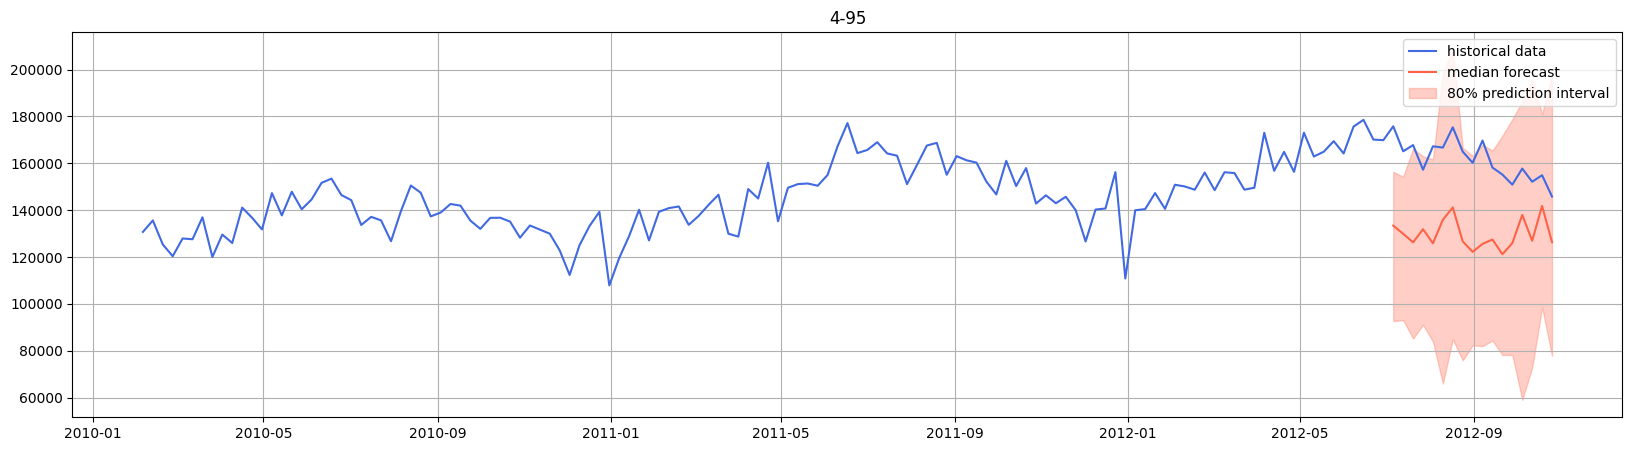

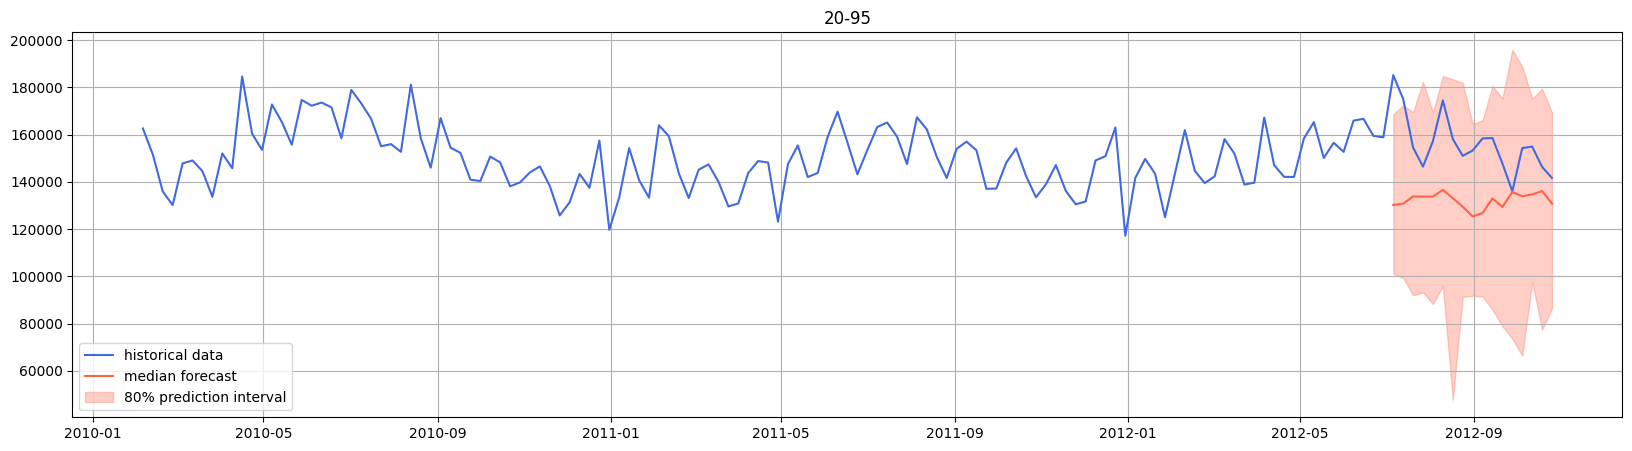

In [10]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:6]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_df[forecast_df["unique_id"] == ts], ts)

### Model Evaluation

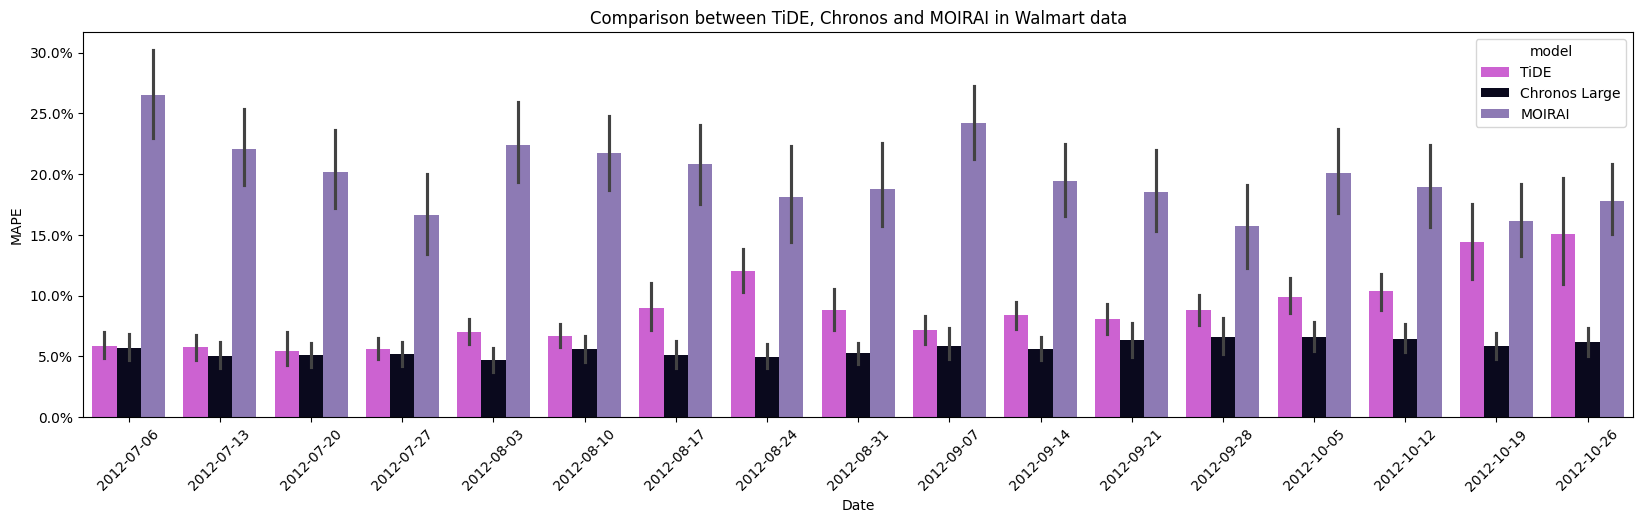

In [11]:
test = pd.read_csv('test_.csv').dropna()
tide_model_df = pd.read_csv('tide.csv')
chronos_large_df = pd.read_csv('chronos_large.csv')
moirai_df = pd.read_csv('moirai.csv')

tide_model_df.rename(columns={'forecast': 'TiDE'}, inplace=True)
chronos_large_df.rename(columns={'forecast': 'Chronos Large'}, inplace=True)
moirai_df.rename(columns={'forecast': 'MOIRAI'}, inplace=True)

model_eval_df = pd.merge(test[['unique_id', 'Date', 'Weekly_Sales']], tide_model_df[['unique_id', 'Date', 'TiDE']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'Date', 'Chronos Large']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, moirai_df[['unique_id', 'Date', 'MOIRAI']], on=['unique_id', 'Date'], how='inner')
model_eval_df['Date'] = pd.to_datetime(model_eval_df['Date'])
utils.plot_model_comparison(model_eval_df)